In [ ]:
!sudo apt-get install python3.9

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib mailcap mime-support
  python3.9-minimal
Suggested packages:
  python3.9-venv binfmt-support
The following NEW packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib mailcap mime-support python3.9
  python3.9-minimal
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,275 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.9-minimal amd64 3.9.19-1+jammy1 [835 kB]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.9-minima

In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1

update-alternatives: using /usr/bin/python3.9 to provide /usr/bin/python3 (python3) in auto mode


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!python --version

Python 3.9.19


In [ ]:
#import libraries
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import re, string
import nltk
import zipfile
import os
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Orthogonal
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

i trained my models in colab so i had to secure that my local tf version is the same (2.15.0) with colab's tf version. A different tf version can't load the models.

In [ ]:
#! pip install --upgrade tensorflow

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
# Function to check if GPU is available and set the device
def get_device():
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        device_name = physical_devices[0].name
        print(f"Running on GPU: {device_name}")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    else:
        device_name = '/CPU:0'
        print("Running on CPU")
    return device_name


I downloaded the datasets for kaggle.
The training dataset has 74681 entries and the test dataset 1000 entries

In [ ]:
#load the training data
df = pd.read_csv('/content/gdrive/MyDrive/deep learning project1/twitter_training.csv')

In [ ]:
df

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:
#load the testing data
test = pd.read_csv('/content/gdrive/MyDrive/deep learning project1/twitter_test.csv')

In [ ]:
test

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


The dataset has four columns.
The fourth column has the tweets/text.
The third column has the labels of the tweets(irrelevant, negative, neutreal, possitive).
The second column has the name of the game/company/brand, the tweet talks about.
The first column is the ID of the game/company/brand.


In [ ]:
#add headers
df.columns = ['theme_id', 'theme','class_labels','text']
test.columns = ['theme_id', 'theme','class_labels','text']
df

,theme_id,theme,class_labels,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:
test

,theme_id,theme,class_labels,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


I dropped the id of the game/company/brand because i couldn't find any way to use it and the theme. Also i trained a model with a concatenation of the theme and the tweet/text but the results were slightly worse so i kept the model without the concatenation.

In [ ]:
#delete the theme_id and theme columns (not needed for the model)
df.drop(columns=['theme_id', 'theme'], inplace=True)
test.drop(columns=['theme_id', 'theme'], inplace=True)
df

,class_labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [ ]:
test

,class_labels,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class_labels  74681 non-null  object
 1   text          73995 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class_labels  999 non-null    object
 1   text          999 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB


I dropped the entries with null values and the duplicates.

In [ ]:
#check for missing values
df.isnull().sum()

class_labels      0
text            686
dtype: int64

In [ ]:
test.isnull().sum()

class_labels    0
text            0
dtype: int64

In [ ]:
#drop missing values
df.dropna(inplace=True)
df.isnull().sum()

class_labels    0
text            0
dtype: int64

In [ ]:
#check for duplicates
df.duplicated().sum()

4227

In [ ]:
test.duplicated().sum()

1

In [ ]:
#drop duplicates
df.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
test.duplicated().sum()

0

Downloaded all the tools i need from nltk

In [ ]:
#nltk path
nltk_data_dir = '/content/gdrive/MyDrive/deep learning project1/nltk_rep'
wordnet_zip_path = os.path.join(nltk_data_dir, 'corpora/wordnet.zip')
omw_zip_path = os.path.join(nltk_data_dir, 'corpora/omw-1.4.zip')
wordnet_dir = os.path.join(nltk_data_dir, 'corpora/wordnet')
omw_dir = os.path.join(nltk_data_dir, 'corpora/omw-1.4')
punkt_dir = os.path.join(nltk_data_dir, 'corpora/punkt')
stopwords_dir = os.path.join(nltk_data_dir, 'corpora/stopwords')

for some reason it duplicates the wordnet and omw folders and i have to delele them manually

In [ ]:
#check if the files are already downloaded
os.makedirs(nltk_data_dir, exist_ok=True)

In [ ]:
#Download NLTK data if not already downloaded
if not os.path.exists(wordnet_zip_path):
    nltk.download('wordnet', download_dir=nltk_data_dir)
if not os.path.exists(omw_zip_path):
    nltk.download('omw-1.4', download_dir=nltk_data_dir)
if not os.path.exists(stopwords_dir):
    nltk.download('stopwords', download_dir=nltk_data_dir)
#if not os.path.exists(punkt_dir):
    #nltk.download('punkt', download_dir=nltk_data_dir)


wordnet and omw were zipped so i had to unzip them

In [ ]:
#define function to unzip files
def unzip_file(zip_path, extract_to):
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

In [ ]:
#unzip the downloaded files if not already unzipped
unzip_file(wordnet_zip_path, wordnet_dir)
unzip_file(omw_zip_path, omw_dir)

In [ ]:
#add nlltk path
nltk.data.path.append(nltk_data_dir)

In [ ]:
#define that the data is accessible
try:
    from nltk.corpus import wordnet
    print("WordNet is available.")
except Exception as e:
    print(f"Error accessing WordNet: {e}")

try:
    from nltk.corpus import wordnet
    # Access synsets to ensure OMW 1.4 is integrated
    example_synset = wordnet.synsets('example')
    if example_synset:
        print("OMW 1.4 data is integrated and available.")
    else:
        print("OMW 1.4 data is not found.")
except Exception as e:
    print(f"Error accessing OMW 1.4 data: {e}")
try:
    from nltk.corpus import stopwords
    print("Stopwords are available.")
except Exception as e:
    print(f"Error accessing Stopwords: {e}")
#try:
    #from nltk.tokenize.punkt import WordPunctTokenizer
    #print("punkt are available.")
#except Exception as e:
    #print(f"Error accessing punkt: {e}")

WordNet is available.
OMW 1.4 data is integrated and available.
Stopwords are available.


Creating a function to clean the text. The steps that i did to build this function were: Initialy removed the extra spaces, special characters, single characters and non alphabetical characters. Then i change all the characters to lower, split the text into single words and lemmatize all the words. Also i removed all the words stopwords library includes and after trials found out that the accuracy increases if i remove  the duplicates from the same entry. Finally, after all these, the removing of all words with length< 2 improved  my model.

In [ ]:
def process_text(text):
    #remove extra spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    #remove special characters
    text = re.sub(r'\W', ' ', str(text))
    #remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    #remove non alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = text.lower()

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 2]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

In [ ]:
# get the text column to apply the function in  the training data
x=df.drop('class_labels',axis=1)
x_bert=df.drop('class_labels',axis=1)
y=df.class_labels
y_bert=df.class_labels
texts=list(x['text'])

In [ ]:
x

,text
0,I am coming to the borders and I will kill you...
1,im getting on borderlands and i will kill you ...
2,im coming on borderlands and i will murder you...
3,im getting on borderlands 2 and i will murder ...
4,im getting into borderlands and i can murder y...
...,...
74676,Just realized that the Windows partition of my...
74677,Just realized that my Mac window partition is ...
74678,Just realized the windows partition of my Mac ...
74679,Just realized between the windows partition of...


In [ ]:
y

0        Positive
1        Positive
2        Positive
3        Positive
4        Positive
           ...   
74676    Positive
74677    Positive
74678    Positive
74679    Positive
74680    Positive
Name: class_labels, Length: 69768, dtype: object

In [ ]:
texts

In [ ]:
# get the text column to apply the function in  the testing data
x_test=test.drop('class_labels',axis=1)
y_test=test.class_labels
texts_test=list(x_test['text'])

In [ ]:
#clean the texts
cleaned_text = [process_text(text) for text in texts]
cleaned_text_test = [process_text(text) for text in texts_test]

In [ ]:
cleaned_text

In [ ]:
cleaned_text_test

already have test data so i just split for validation

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(cleaned_text, y, test_size=0.1, random_state=42)

Using tf.keras.preprocessing for tokenization and zero padding the train, validation and test_cleaned_texts.

In [ ]:
# Tokenize the text data
from tensorflow.keras.preprocessing.text import Tokenizer
max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_val)
tokenizer.fit_on_texts(cleaned_text_test)
word_idx = tokenizer.word_index
v = len(word_idx)
print("the size of vocab =", v)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(cleaned_text_test)

the size of vocab = 26839


In [ ]:
max_vocab

20000

In [ ]:
X_train

In [ ]:
X_val

In [ ]:
X_test

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train,maxlen=maxlen)
X_val = pad_sequences(X_val,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

In [ ]:
X_train

array([[    0,     0,     0, ...,  3630,   193,   767],
       [    0,     0,     0, ...,     0,   222,   645],
       [    0,     0,     0, ...,     6,     1, 11496],
       ...,
       [    0,     0,     0, ...,   269,   193,   411],
       [    0,     0,     0, ...,     0,  1666,   192],
       [    0,     0,     0, ...,    80,   726,    28]], dtype=int32)

In [ ]:
X_val

array([[    0,     0,     0, ...,   261,  2022,   313],
       [    0,     0,     0, ...,    92,   445,  6147],
       [    0,     0,     0, ...,    32,    78,  2233],
       ...,
       [    0,     0,     0, ...,   154,     2,  1148],
       [    0,     0,     0, ...,   164,    72, 16633],
       [    0,     0,     0, ...,    18, 17292,  9669]], dtype=int32)

In [ ]:
X_test

array([[    0,     0,     0, ...,  1145,  6677,  9807],
       [    0,     0,     0, ...,  2092, 12003,  5168],
       [    0,     0,     0, ...,   516,  1120,     2],
       ...,
       [    0,     0,     0, ...,   152,    22,   353],
       [    0,     0,     0, ...,    50,   518,   113],
       [    0,     0,     0, ...,  2767,    18, 10720]], dtype=int32)

In [ ]:
y.value_counts()

class_labels
Negative      21237
Positive      19137
Neutral       17110
Irrelevant    12284
Name: count, dtype: int64

In [ ]:
# Set device
device = get_device()

Running on CPU


i tried to create "the best" learning rate function for this dataset/model/metric with the assist of early stopping

In [ ]:
# Define the learning rate
def lr_schedule(epoch, lr):
    if epoch < 20:
        return 0.0001
    elif epoch < 40:
        return 0.00001
    elif epoch < 60:
        return 0.000001
    else:
        return 0.0000001

In [ ]:
# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

Define the input shape of the model (100) and the embedding layer converts the input sequences into 100-dimensional dense vectors. Then i added a dropout layer to avoid overfitting and after that the bidirectional LSTM  layer which processes the sequence in both forward and backward directions, capturing information from both past and future contexts in the sequence. Finally, there are two dense layers. The first one is a fully connected layer that uses the relu activation function and learns high-level  features from the LSTM output. The second dense layer uses the softmax activation function and works as output, which is a probability distribution over the four classes (Positive, Negative, Neutral, Irrelevant).

In [ ]:
D=100
# layers
inputt=Input(shape=(maxlen,))
x = Embedding(input_dim=v+1, output_dim=D)(inputt)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(150))(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

In [ ]:
# Define the model with the device
#with tf.device(device):
model = Model(inputs=inputt, outputs=x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2684000   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 bidirectional (Bidirection  (None, 300)               301200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                             

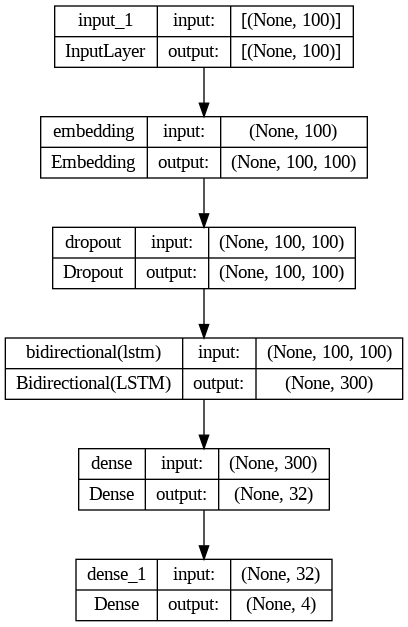

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True)

In model compilation i used Adam as optimizer with initialized learning rate=0.0001 for the first epoch and as loss function i used the categorical_crossentropy since it is a multi-class classification problem.

In [ ]:
# Define optimizer with specified learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the device being used
print(f"Using device: {device}")

Using device: /CPU:0


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
y_train_encoded

array([0, 1, 3, ..., 1, 2, 3])

In [ ]:
# Convert the encoded labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_val_one_hot = tf.keras.utils.to_categorical(y_val_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)

In [ ]:
y_train_one_hot

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

As i mentioned before i used early stopping callback to stop the training process when the monitored metric stop improving. As monitor i used the val_loss with patience=10.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_path = '/content/gdrive/MyDrive/deep learning project1/LSTM200_5_sentiment_model.h5'

Also created a model_checkpoint to monitoring the val_loss after each epoch and save the best model to path. A history pickle file saved aswell for the creation of model accuracy and model loss visualizations.

In [ ]:
# Check if the model already exists to avoid retraining
try:
        trained_model = tf.keras.models.load_model(model_path)
        print(f"Model loaded from {model_path}")
except IOError:
        model_checkpoint = ModelCheckpoint(filepath=model_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min',
                                   save_weights_only=False,
                                   verbose=1)
        # Train the model
        history = model.fit(X_train, y_train_one_hot, epochs=100,batch_size=128, validation_data=(X_val, y_val_one_hot), callbacks=[early_stopping, model_checkpoint, lr_scheduler])
        # Save the model after training
        model.save(model_path)
        with open('/content/gdrive/MyDrive/deep learning project1/history.pkl', 'wb') as file:
            pickle.dump(history, file)
        print(f"Model saved to {model_path}")
        trained_model = tf.keras.models.load_model(model_path)

Model loaded from /content/gdrive/MyDrive/deep learning project1/LSTM200_5_sentiment_model.h5


In [ ]:
with open('/content/gdrive/MyDrive/deep learning project1/history.pkl', 'rb') as file:
   history = pickle.load(file)

In [ ]:
y_train_pred = trained_model.predict(X_train)
y_train_pred

1963/1963 [==============================] - 242s 123ms/step


array([[9.9984407e-01, 5.7055570e-07, 1.2456307e-04, 3.0827323e-05],
       [3.7059385e-02, 7.5725919e-01, 3.6889292e-02, 1.6879205e-01],
       [3.2990137e-03, 4.2813318e-04, 1.3143862e-04, 9.9614131e-01],
       ...,
       [2.0464160e-04, 9.9585330e-01, 3.4943472e-03, 4.4767838e-04],
       [2.4483467e-03, 3.1188603e-02, 9.6300262e-01, 3.3603390e-03],
       [1.2147013e-03, 3.2379851e-04, 7.3776334e-03, 9.9108386e-01]],
      dtype=float32)

In [ ]:
#y_train_pred.shape

In [ ]:
#y_test_one_hot.shape

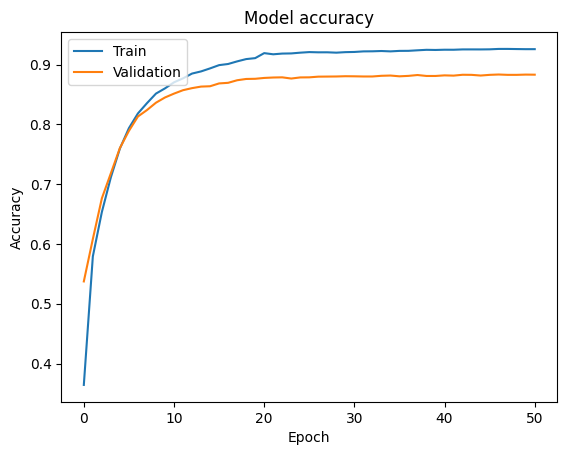

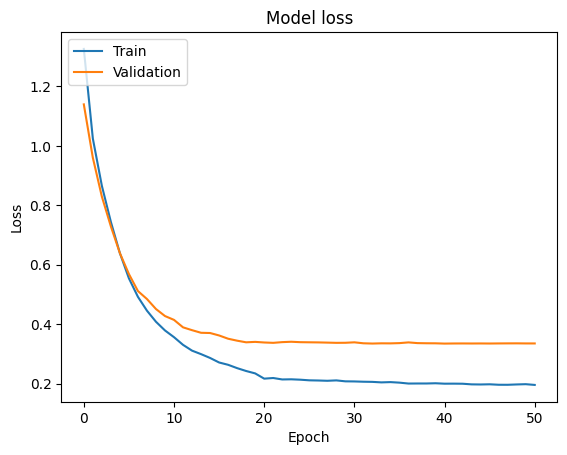

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
X_test

array([[    0,     0,     0, ...,  1145,  6677,  9807],
       [    0,     0,     0, ...,  2092, 12003,  5168],
       [    0,     0,     0, ...,   516,  1120,     2],
       ...,
       [    0,     0,     0, ...,   152,    22,   353],
       [    0,     0,     0, ...,    50,   518,   113],
       [    0,     0,     0, ...,  2767,    18, 10720]], dtype=int32)

In [ ]:
model_probs = trained_model.predict(X_test)

32/32 [==============================] - 3s 107ms/step


The output of the softmax for each tweet is four probability values (one for each class label) and has the form like this [0.2, 0.1, 0.1, 0.6]. The script below finds the index with the maximum probability in each row of model_probs and set this possition to 1 in model_pred (initially model_pred has the same shape as model_probs but it was full of zeros) while it lets all the other probabilities to 0.

In [ ]:
model_pred = np.zeros_like(model_probs)
# Find the index of the maximum probability in each row
max_indices = np.argmax(model_probs, axis=1)
# Set the maximum probability position to 1
model_pred[np.arange(model_probs.shape[0]), max_indices] = 1
print(model_pred)

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


As a first view of evaluation i flattened the ground truth(y_test_one_hot) and the predictions of the model to get a binary classification report (for 0s and 1s)  

In [ ]:
# Flatten the arrays for evaluation
y_true = y_test_one_hot.flatten()
y_pred = model_pred.flatten()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

In [ ]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9785
Precision: 0.9713
Recall: 0.9713
F1 Score: 0.9713


In [ ]:
# Print detailed binary classification report
print('\n(binary)Classification Report for:')
print(classification_report(y_true, y_pred))


(binary)Classification Report for:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2994
         1.0       0.96      0.96      0.96       998

    accuracy                           0.98      3992
   macro avg       0.97      0.97      0.97      3992
weighted avg       0.98      0.98      0.98      3992



After that we see the evaluation metrics for each class and the confusion matrix.

In [ ]:
#create max_indices for y_test_one_hot and use it as ground truth
test_max_indices = np.argmax(y_test_one_hot, axis=1)

In [ ]:
# Define the labels
labels = ['irrelevant', 'negative', 'neutral', 'positive']

In [ ]:
# Map the indices to the corresponding labels
predicted_labels = [labels[idx] for idx in max_indices]
ground_truth_labels = [labels[idx] for idx in test_max_indices]

In [ ]:
report = classification_report(ground_truth_labels, predicted_labels, target_names=labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

  irrelevant       0.98      0.94      0.96       171
    negative       0.94      0.98      0.96       266
     neutral       0.98      0.94      0.96       285
    positive       0.94      0.96      0.95       276

    accuracy                           0.96       998
   macro avg       0.96      0.96      0.96       998
weighted avg       0.96      0.96      0.96       998



In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels, labels=labels)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[161   4   1   5]
 [  1 260   2   3]
 [  1   8 268   8]
 [  1   6   3 266]]


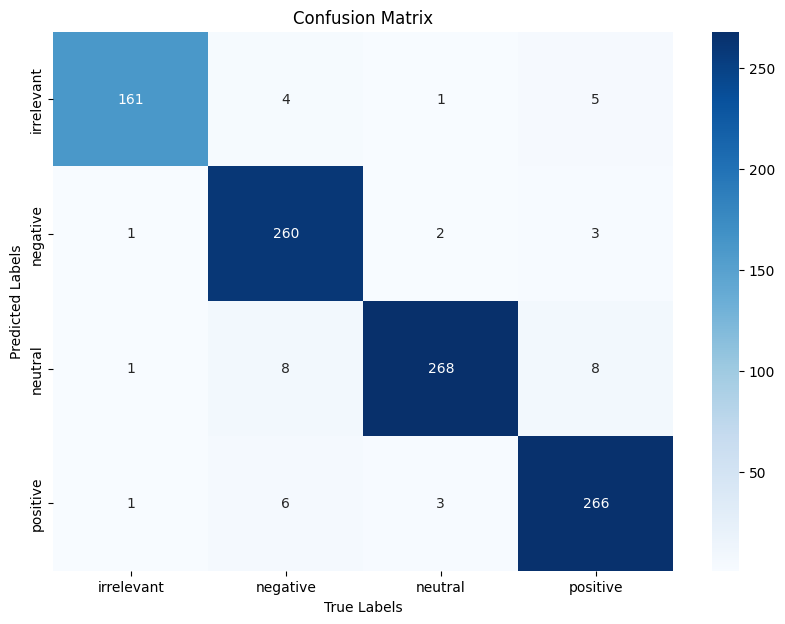

In [ ]:
# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

**Irrelevant (Class 0)**

 -True Positives: 161

 -False Negatives: 4 (classified as negative), 1 (classified as neutral), 5 (classified as positive)

 -False Positives: 1 (negative instance classified as irrelevant), 1 (neutral instance classified as irrelevant), 1 (positive instance classified as irrelevant)


**Negative (Class 1)**

 -True Positives: 260

 -False Negatives: 1 (classified as irrelevant), 2 (classified as neutral), 3 (classified as positive)

 -False Positives: 4 (irrelevant instances classified as negative), 8 (neutral instances classified as negative), 6 (positive instances classified as negative)


**Neutral (Class 2)**

 -True Positives: 268

 -False Negatives: 1 (classified as irrelevant), 8 (classified as negative), 8 (classified as positive)

 -False Positives: 1 (irrelevant instance classified as neutral), 2 (negative instances classified as neutral), 3 (positive instances classified as neutral)


**Positive (Class 3)**

 -True Positives: 266

 -False Negatives: 5 (classified as irrelevant), 3 (classified as negative), 8 (classified as neutral)

 -False Positives: 5 (irrelevant instances classified as positive), 3 (negative instances classified as positive), 8 (neutral instances classified as positive)

In [ ]:
#just a weird sample to check that it classifies it on the correct class
sample = "i killed my neighbor and i will play dota2 all night long"
sample = process_text(sample)
sample = tokenizer.texts_to_sequences([sample])
sample = pad_sequences(sample, maxlen=maxlen)
sample = trained_model.predict(sample)
model_pred = np.zeros_like(sample)
max_indices = np.argmax(sample, axis=1)
model_pred[np.arange(sample.shape[0]), max_indices] = 1
print(model_pred)

1/1 [==============================] - 0s 78ms/step
[[0. 0. 0. 1.]]


[irrelevant, negative, neutreal, possitive]

# Import a pre-trained Bert model


After the training of the bi-LSTM model i want to check its results versus  a pre-trained Bert model.

In [ ]:
from transformers import BertTokenizerFast
from transformers import TFBertModel

In [ ]:
df

,class_labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


These functions work together to clean the text data by:

Removing newlines, mentions, URLs, non-ASCII characters, punctuation, and certain specific characters.

Cleaning hashtags by removing them from the end of the text and stripping the # symbol from words in the middle.

Filtering out words containing special characters

Removing extra spaces to ensure the text is properly formatted with single spaces between words.

In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
#def strip_emoji(text):
    #return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
print(df['text'])

0        I am coming to the borders and I will kill you...
1        im getting on borderlands and i will kill you ...
2        im coming on borderlands and i will murder you...
3        im getting on borderlands 2 and i will murder ...
4        im getting into borderlands and i can murder y...
                               ...                        
74676    Just realized that the Windows partition of my...
74677    Just realized that my Mac window partition is ...
74678    Just realized the windows partition of my Mac ...
74679    Just realized between the windows partition of...
74680    Just like the windows partition of my Mac is l...
Name: text, Length: 69768, dtype: object


In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

texts_new_test = []
for t in test.text:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [ ]:
df['text_clean'] = texts_new
test['text_clean'] = texts_new_test

In [ ]:
df['text_clean']

0        i am coming to the borders and i will kill you...
1        im getting on borderlands and i will kill you all
2        im coming on borderlands and i will murder you...
3        im getting on borderlands 2 and i will murder ...
4        im getting into borderlands and i can murder y...
                               ...                        
74676    just realized that the windows partition of my...
74677    just realized that my mac window partition is ...
74678    just realized the windows partition of my mac ...
74679    just realized between the windows partition of...
74680    just like the windows partition of my mac is l...
Name: text_clean, Length: 69768, dtype: object

In [ ]:
df['text_clean'][1:8].values

array(['im getting on borderlands and i will kill you all',
       'im coming on borderlands and i will murder you all',
       'im getting on borderlands 2 and i will murder you me all',
       'im getting into borderlands and i can murder you all',
       'so i spent a few hours making something for fun if you dont know i am a huge fan and maya is one of my favorite characters so i decided to make myself a wallpaper for my pc here is the original image versus the creation i made enjoy pictwittercommlsi5wf9jg',
       'so i spent a couple of hours doing something for fun if you dont know that im a huge borderlands fan and maya is one of my favorite characters i decided to make a wallpaper for my pc heres the original picture compared to the creation i made have fun pictwittercom mlsi5wf9jg',
       'so i spent a few hours doing something for fun if you dont know im a huge borderlands fan and maya is one of my favorite characters'],
      dtype=object)

i tried to filter out all short tweets cause they don't contain enough information.

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df['text_len'] = text_len

df = df[df['text_len'] > 4]
df_test = test[test['text_len'] > 4]

using BertTokenizerFast to convert text into a format suitable for input into Bert model.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Calculate the maximum token length in the cleaned data.

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 169


In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

In [ ]:
df['token_lens'] = token_lens

<ipython-input-104-b06175d1d9b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['token_lens'] = token_lens


text vs text_clean

In [ ]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,class_labels,text,text_clean,text_len,token_lens
8545,Positive,I REALLY HAVE THE OVERWATCH RN GAME. SEA SEA S...,i really have the overwatch rn game sea sea se...,166,169
70939,Neutral,The event dedicated to Victory Day in the Grea...,the event dedicated to victory day in the grea...,150,154
57361,Neutral,.... mixer.com / makavelincheese or makavelinc...,mixercom makavelincheese or makavelincheese sh...,35,132
28993,Negative,"At the same time, there are many low-income co...",at the same time there are many lowincome coun...,106,111
32593,Positive,playing in 0.3% league tile Clothing is SO enj...,playing in 03 league tile clothing is so enjoy...,105,107
3097,Negative,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",italy italy italy italy italy italy italy ital...,99,101
10255,Neutral,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",italy italy italy italy italy italy italy ital...,99,101
18127,Positive,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",italy italy italy italy italy italy italy ital...,99,101
7393,Positive,I knew that the LMEPA PA PA PA PA PA PA PA PA ...,i knew that the lmepa pa pa pa pa pa pa pa pa ...,97,101
3967,Irrelevant,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",italy italy italy italy italy italy italy ital...,99,101


In [ ]:
df = df.iloc[12:]
df.head()

,class_labels,text,text_clean,text_len,token_lens
39360,Neutral,AEL Uni Cup East Group. R1 Bye. R2 WLW. R3 WW....,ael uni cup east group r1 bye r2 wlw r3 ww win...,48,96
39362,Neutral,AEL Uni Cup East Group. R1 Bye. R2 WLW. R3 WW....,ael uni cup east group r1 bye r2 wlw r3 ww win...,46,96
74107,Neutral,Nvidia X 3080 cards sell for thousands on eBay...,nvidia x 3080 cards sell for thousands on ebay...,61,94
25741,Negative,@ Ubisoft @ increased Please Make A Constant 6...,ubisoft increased please make a constant 60fps...,73,93
73887,Neutral,"HP HP ENVY x360 15.6"". screen. 12 GB DDR3L, 25...",hp hp envy x360 156 screen 12 gb ddr3l 256ssd ...,51,91


Shuffle df to avoid biases (just in case)

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

also checking the text vs text_clean on test dataset

In [ ]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 80


In [ ]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

In [ ]:
df_test['token_lens'] = token_lens_test

<ipython-input-111-822c801c9fe9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['token_lens'] = token_lens_test


In [ ]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,class_labels,text,text_clean,text_len,token_lens
481,Positive,Nice to bow you\n\nThis my Creepypasta/Assassi...,nice to bow you this my creepypastaassassins c...,47,80
299,Irrelevant,HOW TO IMPRESS INDIAN GIRL\nsahilyaduvanshi.in...,how to impress indian girl sahilyaduvanshiinlo...,28,76
518,Neutral,Dart Against Humanity Ep. 79 (S5 E4): The New ...,dart against humanity ep 79 s5 e4 the new not ...,26,75
230,Irrelevant,We are pleased to announce the names of the re...,we are pleased to announce the names of the re...,37,75
677,Neutral,Amazing deal for you!\n\nLenovo Legion Y540 9t...,amazing deal for you lenovo legion y540 9th ge...,33,74
462,Irrelevant,Leaked FIFA 21 GTA 6 gameplay\nopen the link f...,leaked fifa 21 gta 6 gameplay open the link fo...,44,73
126,Neutral,Early adopters get arsed once again.\nAs I've ...,early adopters get arsed once again as ive pro...,50,73
152,Neutral,I didn't have massive success in #IndieApril b...,i didnt have massive success in indieapril but...,48,72
869,Neutral,Want awesome hosting for #gmod #minecraft #tea...,want awesome hosting for gmod minecraft teamfo...,34,72
615,Irrelevant,It’s now been over 18 years since I was a beta...,its now been over 18 years since i was a beta ...,48,71


In [ ]:
df_test = df_test.iloc[5:]
df_test.head(3)

,class_labels,text,text_clean,text_len,token_lens
462,Irrelevant,Leaked FIFA 21 GTA 6 gameplay\nopen the link f...,leaked fifa 21 gta 6 gameplay open the link fo...,44,73
126,Neutral,Early adopters get arsed once again.\nAs I've ...,early adopters get arsed once again as ive pro...,50,73
152,Neutral,I didn't have massive success in #IndieApril b...,i didnt have massive success in indieapril but...,48,72


and shuffle test_df aswell

In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [ ]:
df['class_labels'].value_counts()

class_labels
Negative      18985
Positive      16498
Neutral       15799
Irrelevant    11046
Name: count, dtype: int64

In [ ]:
df['class_labels'] = df['class_labels'].map({'Irrelevant':1,'Negative':2,'Neutral':3,'Positive':4})
df_test['class_labels'] = df_test['class_labels'].map({'Irrelevant':1,'Negative':2,'Neutral':3,'Positive':4})

Class Balancing by RandomOverSampler

Oversampling the df to remove bias towards the majority classes.

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['class_labels']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'class_labels']);

In [ ]:
#train_os['class_labels'].value_counts()

In [ ]:
X = train_os['text_clean'].values
y = train_os['class_labels'].values

Like before i already have my test data so i just split to get validation

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['class_labels'].values

One hot encoding

After performing some tests, by using one hot encoding i achieved higher accuracy like in bi-LSTM. For this reason i will choose one hot enconding over label encoding for Bert model too.

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 68346
VALIDATION DATA: 7594
TESTING DATA: 910


In [ ]:
MAX_LEN=128

Set and apply the tokenizer function to the train, validation and test sets. After that i get the input_ids and attention_masks.

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [ ]:
#import the Bert model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Created a custom function to host the pre trained BERT model, and like before, attach to it a 4 neurons output layer, necessary to perform the classification of the four different classes of the dataset

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.00001,
        decay_steps=10000,
        decay_rate=0.9
    )
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    # Pass input tensors to bert_model, not Keras Input layers
    embeddings = bert_model(input_ids, attention_mask=attention_masks)[1]

    output = tf.keras.layers.Dense(4, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [ ]:
# Check for out-of-vocabulary tokens
out_of_vocab_tokens = set()
for text in X_train:
    for token in tokenizer.tokenize(text):
        if token not in tokenizer.vocab:
            out_of_vocab_tokens.add(token)

if out_of_vocab_tokens:
    print("Out-of-vocabulary tokens found:", out_of_vocab_tokens)
    # Handle out-of-vocabulary tokens
else:
    print("No out-of-vocabulary tokens found.")

No out-of-vocabulary tokens found.


In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [ ]:
# Define model callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_path = '/content/gdrive/MyDrive/deep learning project1/BERT_sentiment_model.keras'

Tuning the Bert Model

In [ ]:
# Check if the weights already exists to avoid retraining
try:
        model.load_weights(model_path)
        print(f"Weights loaded from {model_path}")
except IOError:
        bert_model_checkpoint = ModelCheckpoint(filepath=model_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min',
                                   save_weights_only=True,
                                   verbose=1)
        # Train the model
        bert_history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid),
                                 epochs=4, batch_size=64, callbacks=[early_stopping, bert_model_checkpoint])
        # Save the model after training
        #bert_model.save_weights(model_path)
        #with open(r'C:\Users\User\Desktop\deep learning project1\bert_history.pkl', 'wb') as file:
            #pickle.dump(bert_history, file)
        print(f"Weights saved to {model_path}")
        model.load_weights(model_path)

Weights loaded from /content/gdrive/MyDrive/deep learning project1/BERT_sentiment_model.keras


In [ ]:
#bert_history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32, callbacks=[early_stopping, bert_model_checkpoint])

In [ ]:
test_labels = tf.convert_to_tensor(df_test['class_labels'])

In [ ]:
test_predictions = model.predict([test_input_ids, test_attention_masks])

29/29 [==============================] - 527s 17s/step


In [ ]:
test_pred_labels = np.argmax(test_predictions, axis=1)

In [ ]:
y_test_true = np.argmax(y_test, axis=1)
print("Bert_Accuracy:", accuracy_score(y_test_true, test_pred_labels))
print("Bert_Classification Report:")
print(classification_report(y_test_true, test_pred_labels, target_names=['Irrelevant', 'Negative', 'Neutral', 'Positive']))

Bert_Accuracy: 0.9516483516483516
Bert_Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.90      0.96      0.93       158
    Negative       0.98      0.97      0.97       244
     Neutral       0.97      0.92      0.94       273
    Positive       0.95      0.97      0.96       235

    accuracy                           0.95       910
   macro avg       0.95      0.95      0.95       910
weighted avg       0.95      0.95      0.95       910



In [ ]:
cm = confusion_matrix(y_test_true, test_pred_labels)
print("Bert_Confusion Matrix:")
print(cm)

Bert_Confusion Matrix:
[[151   2   3   2]
 [  2 237   3   2]
 [ 10   3 251   9]
 [  4   1   3 227]]


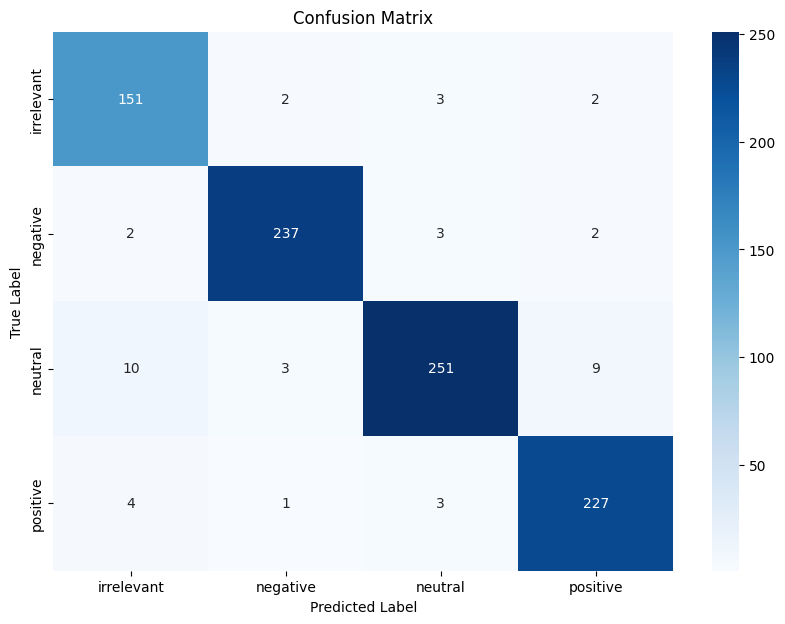

In [ ]:
# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Conclusion

With a first look we can say that the bi-LSTM model does slightly better versus Bert model BUT the Bert model fine tuned for only 4 epochs due to time constraints (each epoch took approximately 30 minutes).Despite this, the bi-LSTM model stopped without further improvement, indicating potential convergence, so it's not a really fair comparison.